In [1]:
#DoorDash Arrival Time Prediction
import pandas as pd
import numpy as np
from datetime import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor  
from statsmodels.tools.tools import add_constant  
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from scipy.stats import sem
from sklearn.cluster import KMeans
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance

In [ ]:
#Create a pandas dataframe 
dash_data = pd.read_csv("/Users/user/Downloads/historical_data.csv")
#print(dash_data.head(10))

dash_data = pd.DataFrame(dash_data)

dash_data.head(10)

In [ ]:
#convert times to datetime format so we can preform operation
dash_data['created_at'] = pd.to_datetime(dash_data['created_at'], format="%Y-%m-%d %H:%M:%S")
dash_data['actual_delivery_time'] = pd.to_datetime(dash_data['actual_delivery_time'], format="%Y-%m-%d %H:%M:%S")


#y = (dash_data['actual_delivery_time']-dash_data['created_at'])
#Insert a new column that represents the total time it takes to arrive
#We do this by subtracting the starting time and the actual delivery time
y =(dash_data['actual_delivery_time']-dash_data['created_at']).dt.total_seconds()
dash_data.insert(3 , "time_to_arrive" ,y)
print(dash_data)



In [4]:
#Create a new feature that represents the number of availible doordashers (total_onshift_dashers - (total_busy_dashers))
ratio_free_dashers = dash_data["total_busy_dashers"]/dash_data["total_onshift_dashers"]
ratio_free_dashers
dash_data.insert(14 , "total_free_dashers" ,ratio_free_dashers)


In [5]:
#Check how many Nulls in total
null_count = dash_data.isna().sum()
print(null_count)

market_id                                         987
created_at                                          0
actual_delivery_time                                7
time_to_arrive                                      7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_free_dashers                              19838
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64


In [6]:
#We notice some  categorical variables that we may want to one hot encode.  order_protocol , market_id , store_id, and store_primary_category
#Check unique values for store_id
dash_data["store_id"].nunique()

6743

In [7]:
dash_data["market_id"].nunique()

6

In [8]:
dash_data["store_primary_category"].nunique()

74

In [9]:
dash_data["order_protocol"].nunique()

7

In [11]:
#We want to avoid hot encoding feature vectors with large number of distinct values (curse of dimensionality) we know for a fact we can convert the order_protocol and the "market_id"
market_id_dummy = pd.get_dummies(dash_data["market_id"])
market_id_dummy = market_id_dummy.add_prefix("market_id_")






In [12]:
order_protocol_dummy = pd.get_dummies(dash_data["order_protocol"])
order_protocol_dummy = order_protocol_dummy.add_prefix("order_protocol_")


In [13]:
#We luckily have store_ids with known values for example for store_id (no NaNs) for example we have store_id 5477 that has already been identified as "mexican" 
#So we can fill the remaining values in accordingly.  
# use the fact that stores with the same "store_id" have the same "store_primary_category".  This isn't always the case we should first test this theory
unique1 = pd.unique(dash_data[["store_primary_category" , "store_id"]].values.ravel("K"))
print(len(unique1))

#Unique store_ids
print(len(dash_data["store_id"].unique()))

#As we can see there are some cases that we have the same store_id but different store_primary_category.  However this difference is very small so we can go ahead and assume that 
#store_id corresponds to the unique store_primary_category


6818
6743


In [14]:
#We can create a reference dictionary for all the store_ids
#First create a list of the unique values of store_id
unique_store_id = dash_data["store_id"].unique().tolist()
#Put them in a hash
store_id_hash = {store_id : (dash_data[dash_data.store_id == store_id].store_primary_category.mode()) for store_id in unique_store_id}
#After this each store_id will correspond to one store_primary cartegory


In [15]:
#Remember that we have some store_ids in which the mode of the primary category will be null since there is no other valid category
#Remove based off size
print(store_id_hash[1845].size)
print(store_id_hash[3879].size)

1
0


In [16]:
#Create a list of the store_ids such that there are only null_values
null_list = []
for i in store_id_hash.keys():
    if store_id_hash[i].size == 0:
        null_list.append(i)


In [17]:

len(null_list)

#this list contains all such values that we only have null within the same store_id.  I.E there is no way to pinpoint a primary category
#174 is not a significant amount
#Delete these items from the hashmap and the dataframe.
for i in null_list:
    del store_id_hash[i]

#store_id_hash



In [18]:

#We need to parse out just the name
for i in store_id_hash.keys():
        store_id_hash[i] = store_id_hash[i].values[0]



In [19]:
#Add this to the data
dash_data["store_primary_category"]=dash_data["store_primary_category"].fillna(dash_data["store_id"].map(store_id_hash))

In [20]:
dash_data.head(10)

,market_id,created_at,actual_delivery_time,time_to_arrive,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_free_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,3779.0,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,0.424242,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,4024.0,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.000000,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,1781.0,5477,indian,1.0,1,1900,1,1900,1900,1.0,0.0,0.000000,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,3075.0,5477,indian,1.0,6,6900,5,600,1800,1.0,1.0,1.000000,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,2390.0,5477,indian,1.0,3,3900,3,1100,1600,6.0,6.0,1.000000,9.0,446,650.0
5,3.0,2015-01-28 20:30:38,2015-01-28 21:08:58,2300.0,5477,indian,1.0,3,5000,3,1500,1900,2.0,2.0,1.000000,2.0,446,338.0
6,3.0,2015-01-31 02:16:36,2015-01-31 02:43:00,1584.0,5477,indian,1.0,2,3900,2,1200,2700,10.0,9.0,0.900000,9.0,446,638.0
7,3.0,2015-02-12 03:03:35,2015-02-12 03:36:20,1965.0,5477,indian,1.0,4,4850,4,750,1800,7.0,8.0,1.142857,7.0,446,626.0
8,2.0,2015-02-16 00:11:35,2015-02-16 00:38:01,1586.0,5477,indian,3.0,4,4771,3,820,1604,8.0,6.0,0.750000,18.0,446,289.0
9,3.0,2015-02-18 01:15:45,2015-02-18 02:08:57,3192.0,5477,indian,1.0,2,2100,2,700,1200,2.0,2.0,1.000000,2.0,446,715.0


In [21]:
#The actual delivery time and time to arrvive NaN values are very small so we can go ahead and delete these
dash_data.dropna(subset= "actual_delivery_time" , inplace=True)

print(dash_data.isna().sum())



market_id                                         987
created_at                                          0
actual_delivery_time                                0
time_to_arrive                                      0
store_id                                            0
store_primary_category                            867
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_free_dashers                              19838
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64


In [22]:
#We have cut our value of store_primary_category NaN values signifincantly for that category.  Thus the remaining values can be removed (much smaller portion of information lost)
dash_data.dropna(subset= "store_primary_category", inplace=True)

print(dash_data.isna().sum())

#Resolved the actual_delivery_time_column



market_id                                         986
created_at                                          0
actual_delivery_time                                0
time_to_arrive                                      0
store_id                                            0
store_primary_category                              0
order_protocol                                    992
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16160
total_busy_dashers                              16160
total_free_dashers                              19700
total_outstanding_orders                        16160
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      522
dtype: int64


In [23]:
#Actually found out we didn't have to delete as the one-hot-encode just ignores the Null values
#We hot encoded three variables, this will ignore some of the NaN values but this isn't a significant number (about 3000 obervations out of almost 200,000)
store_primary_cat_dummy = pd.get_dummies(dash_data["store_primary_category"])
store_primary_cat_dummy

,afghan,african,alcohol,alcohol-plus-food,american,argentine,asian,barbecue,belgian,brazilian,...,southern,spanish,steak,sushi,tapas,thai,turkish,vegan,vegetarian,vietnamese
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197423,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197424,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197425,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197426,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
#Add this data to our dataframe
#Also will remove the "store_id".  I suspect that the type of category the restaurant is in will have an effect on arrival time.  However the specific restaurant in that category 
#Probably wont make as much of a difference.
dash_data_train = dash_data.drop(columns=["store_primary_category","created_at","actual_delivery_time","market_id","store_id","order_protocol"])

dash_data_train = pd.concat([dash_data_train,market_id_dummy,order_protocol_dummy,store_primary_cat_dummy],axis =1)

In [25]:
dash_data_train.head(10)

,time_to_arrive,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_free_dashers,total_outstanding_orders,...,southern,spanish,steak,sushi,tapas,thai,turkish,vegan,vegetarian,vietnamese
0,3779.0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,0.424242,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4024.0,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1781.0,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3075.0,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,1.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2390.0,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,1.000000,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2300.0,3.0,5000.0,3.0,1500.0,1900.0,2.0,2.0,1.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1584.0,2.0,3900.0,2.0,1200.0,2700.0,10.0,9.0,0.900000,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1965.0,4.0,4850.0,4.0,750.0,1800.0,7.0,8.0,1.142857,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1586.0,4.0,4771.0,3.0,820.0,1604.0,8.0,6.0,0.750000,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,3192.0,2.0,2100.0,2.0,700.0,1200.0,2.0,2.0,1.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
#Have a problem with total on shift dashers being 0
dash_data_train.loc[dash_data_train["total_onshift_dashers"] == 0] = None
#We can drop the remaining NaN values
dash_data_train.dropna(subset= "total_free_dashers", inplace=True)
dash_data_train.dropna(subset='estimated_store_to_consumer_driving_duration', inplace=True)
dash_data_train.isna().sum()


time_to_arrive        0
total_items           0
subtotal              0
num_distinct_items    0
min_item_price        0
                     ..
thai                  0
turkish               0
vegan                 0
vegetarian            0
vietnamese            0
Length: 99, dtype: int64

In [27]:
#Data is now clean and ready for visualization
dash_data_train.shape

(176345, 99)

In [28]:
#Data visualization
#First thing we can look at is the correlation of the variables.  Off the bat I think we can do without total_onshift_dashers	total_busy_dashers	total_free_dashers 
#however we should first visualize the correlation of all the relevant features of the data
corr_dash = dash_data_train.corr()


<AxesSubplot:>

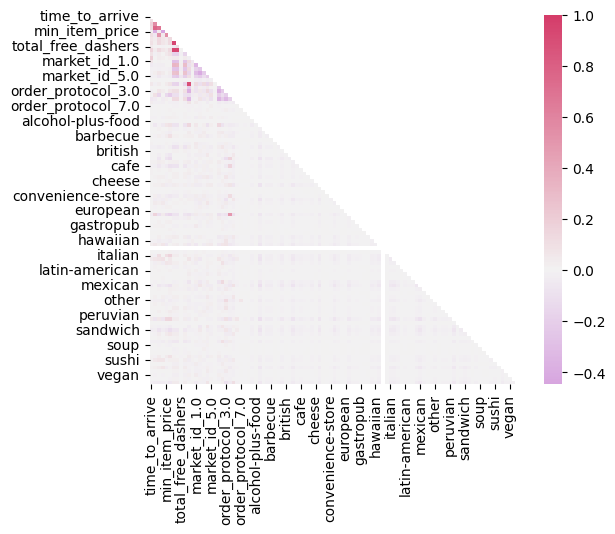

In [343]:
#plot a correlation heatmap
#First want to get rid of redundances in the correlation matrix
#The standard heat map will have a duplicate 'triangle' on top of it, we should delete this by using a mask
#this function will take the lower traingle of such values that share the same corr_values and change them to True (we want to indicate this to the mask call in the heatmap function)
mask= np.triu(np.ones_like(corr_dash , dtype= bool))
plt.plot(figsize = (20,20))
cmap = sns.diverging_palette(300, 0,as_cmap=True)
sns.heatmap(corr_dash , mask = mask , cmap = cmap ,square=True ,vmax=1, center=0)


In [29]:
#We know a value between hawaiian and italian has no values and is worth dropping (perhaps a feature that no longer has any rows in our data but is still present as a column)
#We only have two options indian and indonesian, however it must be indonesian since we can see from the head of the data set India is indeed present
dash_data_train["indonesian"].describe()
dash_data_train = dash_data_train.drop(columns="indonesian")



In [34]:
#First we want to remove the redundancies in our correlation matrix
def remove_redundant(df):
    labels_drop = set()
    col = df.columns
#Want to iterate through the columns
    for i in range(df.shape[1]):
        for j in range(0,i+1):
        #Add to the drop list all the values on the diagnal and above.  Since we will have redundant terms
            labels_drop.add((col[i] , col[j]))
    return labels_drop

def create_corr_ranking(df , n=10):
    #Get the absolute value of the correlation matrix and format it as a vertical list
    abs_corr = df.corr().abs().unstack()
    #Call the function we used recently to remove duplicated
    drop = remove_redundant(df)
    #Drop all the redundant (and identity) pairs and make sure to from highest to smallest
    abs_corr = abs_corr.drop(labels = drop).sort_values(ascending = False)
    return abs_corr[0:n]

rank_dash = create_corr_ranking(dash_data_train , n=10)

print(rank_dash)



            


estimated_order_place_duration  order_protocol_1.0    0.897374
total_items                     num_distinct_items    0.758251
subtotal                        num_distinct_items    0.683044
total_items                     subtotal              0.556653
min_item_price                  max_item_price        0.540322
subtotal                        max_item_price        0.508107
order_protocol_4.0              fast                  0.491450
num_distinct_items              min_item_price        0.447164
total_items                     min_item_price        0.389621
order_protocol_1.0              order_protocol_3.0    0.373220
dtype: float64


In [30]:
#We can see that as expected there is a very high correlation on the total_on_shift_dashers, total_busy_dashers 
dash_data_train = dash_data_train.drop(columns=["total_onshift_dashers","total_busy_dashers"])

#Thereis redundancy in these variables and we can get the same info from "total_free_dashers"



In [ ]:

dash_data_train.info()
#Make the data type consistent throughout
dash_data_train = dash_data_train.astype('float64')


In [32]:
#We should note that categorical variables of the same class should have no correlation between each other.
#We notice that our market_ID's are slightly correlated.  This implies that the classes aren't hugely distinct 
#The joint variability of two categorical variables of different classes should be zero.
#We therefore remove market_IDs
dash_data_train = dash_data_train.drop(columns = ["market_id_1.0","market_id_2.0","market_id_3.0","market_id_4.0","market_id_5.0","market_id_6.0"])

In [36]:
#While on this subject we should revevaluate our correlation for the other categorical variables
rank_dash2 = create_corr_ranking(dash_data_train , n=10)
print(rank_dash2)



estimated_order_place_duration  order_protocol_1.0    0.897374
total_items                     num_distinct_items    0.758251
subtotal                        num_distinct_items    0.683044
total_items                     subtotal              0.556653
min_item_price                  max_item_price        0.540322
subtotal                        max_item_price        0.508107
order_protocol_4.0              fast                  0.491450
num_distinct_items              min_item_price        0.447164
total_items                     min_item_price        0.389621
order_protocol_1.0              order_protocol_3.0    0.373220
dtype: float64


In [37]:
#We notice the same problem with the order protocol variable we will subsequently drop these values
item_counts = dash_data["order_protocol"].nunique(dropna = True)
print(item_counts)
#so we need to delete 7

dash_data_train = dash_data_train.drop(columns=["order_protocol_1.0","order_protocol_2.0","order_protocol_3.0","order_protocol_4.0","order_protocol_5.0","order_protocol_6.0","order_protocol_7.0"])



7


In [351]:
rank_dash2 = create_corr_ranking(dash_data_train , n=20)
print(rank_dash2)

total_items                     num_distinct_items                              0.758251
subtotal                        num_distinct_items                              0.683044
total_items                     subtotal                                        0.556653
min_item_price                  max_item_price                                  0.540322
subtotal                        max_item_price                                  0.508107
num_distinct_items              min_item_price                                  0.447164
total_items                     min_item_price                                  0.389621
time_to_arrive                  estimated_store_to_consumer_driving_duration    0.188631
                                subtotal                                        0.172040
total_outstanding_orders        estimated_order_place_duration                  0.169811
total_items                     fast                                            0.164422
max_item_price       

In [38]:
#We do still have some correlations so we should engineer new features 
#We'll set our cutoff at 0.5 (moderate correlation)
#Create a feature called "price_per_item"
price_per_item = dash_data_train["subtotal"]/dash_data_train["total_items"]
print(price_per_item)



0          860.250000
1         1900.000000
2         1900.000000
3         1150.000000
4         1300.000000
             ...     
197423     463.000000
197424     501.666667
197425     367.200000
197426    1175.000000
197427     651.250000
Length: 176345, dtype: float64


In [39]:
#take the ratio of distinct items and total items
ratio_distinct = dash_data_train["num_distinct_items"]/dash_data_train["total_items"]
print(ratio_distinct)

0         1.000000
1         1.000000
2         1.000000
3         0.833333
4         1.000000
            ...   
197423    1.000000
197424    0.666667
197425    0.600000
197426    1.000000
197427    1.000000
Length: 176345, dtype: float64


In [40]:
#Add these to the dataset and subsequently check the correlation
dash_data_train = dash_data_train.drop(columns=["num_distinct_items" , "subtotal"])
dash_data_train["ratio_distinct"] = ratio_distinct
dash_data_train["price_per_item"] = price_per_item


In [355]:
rankdash3 = create_corr_ranking(dash_data_train , n=10)
print(rankdash3)

min_item_price  price_per_item                                  0.860415
max_item_price  price_per_item                                  0.770077
min_item_price  max_item_price                                  0.540322
total_items     ratio_distinct                                  0.445326
                min_item_price                                  0.389621
                price_per_item                                  0.310873
ratio_distinct  price_per_item                                  0.226667
pizza           price_per_item                                  0.215003
time_to_arrive  estimated_store_to_consumer_driving_duration    0.188631
max_item_price  ratio_distinct                                  0.178025
dtype: float64


In [ ]:
#notice correlation between max and min price and price per item
range_price = dash_data_train["max_item_price"] - dash_data_train["min_item_price"]

dash_data_train = dash_data_train.drop(columns=["max_item_price","min_item_price"])

dash_data_train["range_price"] = range_price

print(dash_data_train.head(10))

In [357]:
dashrank4 = create_corr_ranking(dash_data_train , n=10)
dashrank4
#all our variables have now at worst low correlation (<0.5)

total_items               ratio_distinct                                  0.445326
                          range_price                                     0.333409
                          price_per_item                                  0.310873
ratio_distinct            price_per_item                                  0.226667
pizza                     price_per_item                                  0.215003
time_to_arrive            estimated_store_to_consumer_driving_duration    0.188631
total_outstanding_orders  estimated_order_place_duration                  0.169811
fast                      price_per_item                                  0.167814
total_items               fast                                            0.164422
time_to_arrive            total_outstanding_orders                        0.158209
dtype: float64

In [47]:
#We have calculated the single collineraity between variables now we need to check multicollinearity
#use variance inflation factor
#Want to test only predictor variables
dash_data_predictor = dash_data_train.drop(columns="time_to_arrive").columns.to_list()

def get_vif(features):
    vif_table = pd.DataFrame()
    vif_table["features"] = features
    vif_table["VIF"] = [variance_inflation_factor(dash_data_train[features].values,i) for i in range(len(features))]
    return vif_table.sort_values(by="VIF").reset_index(drop=True)

#VIF_dash = get_vif(dash_data_predictor)
#print(VIF_dash)



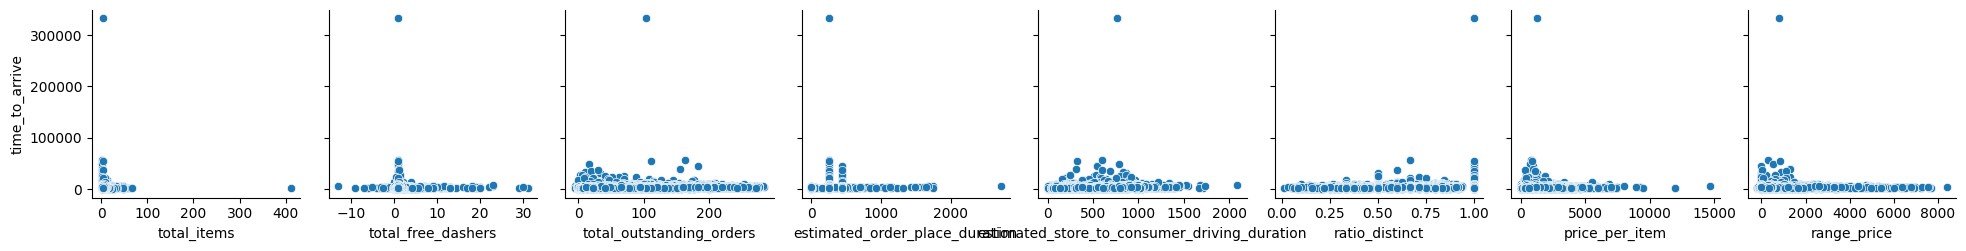

In [48]:
#Outlier analysis
#plot a pairs plot using only the numerical values

sns.pairplot(dash_data_train,y_vars='time_to_arrive',x_vars=['total_items', 'total_free_dashers', 'total_outstanding_orders', 'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration','ratio_distinct', 'price_per_item', 'range_price'])


<AxesSubplot:xlabel='total_items', ylabel='time_to_arrive'>

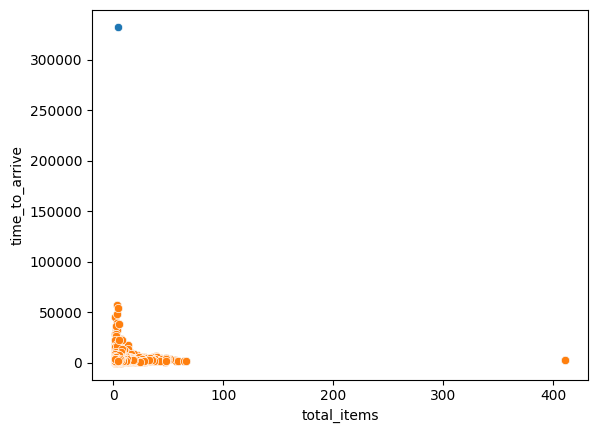

In [49]:
sns.scatterplot(dash_data_train,y='time_to_arrive',x="total_items")
dash_data_train.loc[dash_data_train["time_to_arrive"]>300000]

#create a new dataset without these outliers and see how it effects the model
dash_data_no_outlier = dash_data_train
dash_data_no_outlier.loc[dash_data_no_outlier["time_to_arrive"]>300000] = None
dash_data_no_outlier.dropna(subset= "time_to_arrive",inplace=True)

sns.scatterplot(dash_data_no_outlier , y='time_to_arrive',x="total_items")


In [50]:
dash_data_no_outlier.loc[dash_data_no_outlier["total_items"]>400]

,time_to_arrive,total_items,total_free_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,afghan,african,alcohol,alcohol-plus-food,...,sushi,tapas,thai,turkish,vegan,vegetarian,vietnamese,ratio_distinct,price_per_item,range_price
47231,3055.0,411.0,1.0,39.0,251.0,573.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012165,7.579075,299.0


In [ ]:

print(dash_data_no_outlier.describe())
#This implies this order payed 7cents per item and ordered 400 things. All other features seem to not deviate from the averages too much
#We can infer that either this is a very irregular order that doesnt at all represent the norm.  Or there was an input error.  Regardless we should get rid of this


In [52]:
dash_data_no_outlier.loc[dash_data_no_outlier["total_items"]>400] = None
dash_data_no_outlier.dropna(subset="total_items" , inplace=True)



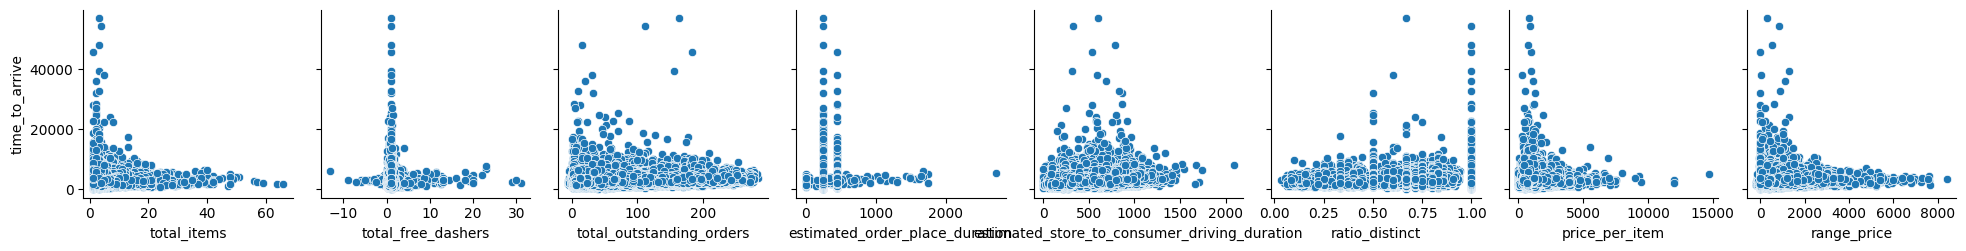

In [53]:
#Plot the new pairs plot
sns.pairplot(dash_data_no_outlier,y_vars='time_to_arrive',x_vars=['total_items', 'total_free_dashers', 'total_outstanding_orders', 'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration','ratio_distinct', 'price_per_item', 'range_price'])

In [54]:
#split data into predictor and target
y = dash_data_no_outlier["time_to_arrive"]
x = dash_data_no_outlier.drop(columns="time_to_arrive")
x_train , x_test, y_train , y_test = train_test_split(x,y , test_size=0.2 ,random_state=100)

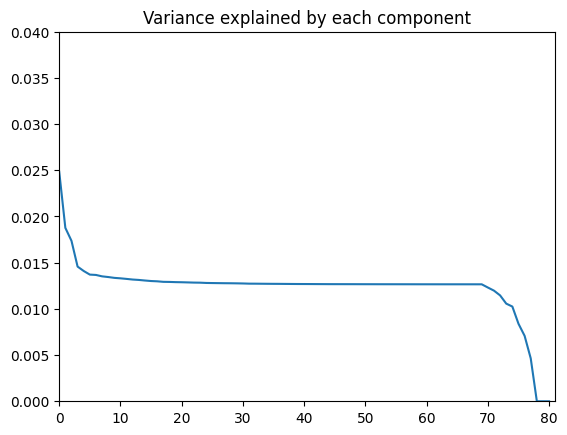

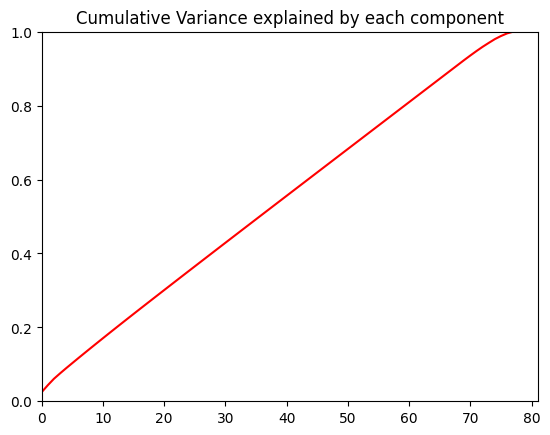

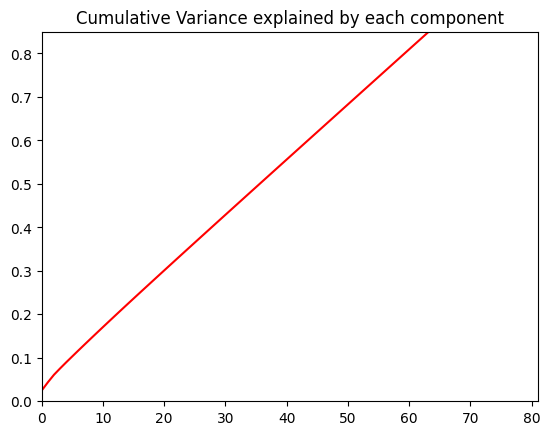

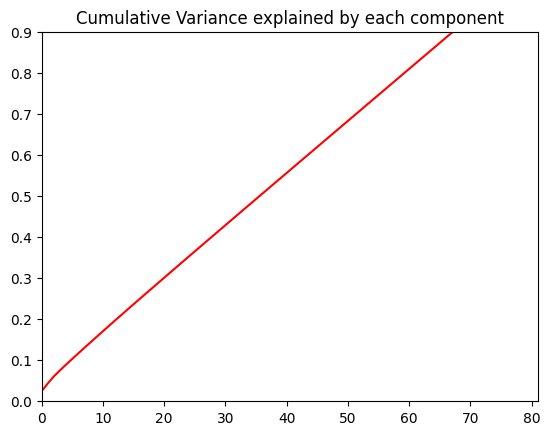

In [55]:
#Use PCA to reduce dimension

scale = StandardScaler()
scalex_train = scale.fit_transform(x_train)
pca = PCA().fit(scalex_train)
exp_var = pca.explained_variance_ratio_
plt.plot(exp_var)
plt.xlim(0,81)
plt.ylim(0,0.04)
plt.title("Variance explained by each component")
plt.show()

#Plot the cumulative variance as we increase the components
plt.plot(np.cumsum(exp_var) , color = "r")
plt.xlim(0,81)
plt.ylim(0,1)
plt.title("Cumulative Variance explained by each component")
plt.show()

#I want to check the cut-off at 85%

plt.plot(np.cumsum(exp_var) , color = "r")
plt.xlim(0,81)
plt.ylim(0,0.85)
plt.title("Cumulative Variance explained by each component")
plt.show()

#Check cutoff at 90%
plt.plot(np.cumsum(exp_var) , color = "r")
plt.xlim(0,81)
plt.ylim(0,0.90)
plt.title("Cumulative Variance explained by each component")
plt.show()

#At about 70 components we can explain 90% of the variance





In [56]:
#We should find the exact components


pca90 = PCA(0.9).fit(scalex_train)
print(pca90.n_components_)

#exactly 70

pca85 = PCA(0.85).fit(scalex_train)
print(pca85.n_components_)

#We should test how good the model is with both 
pca80 = PCA(0.8).fit(scalex_train)
print(pca80.n_components_)



69
65
61


In [57]:
#now we can start fitting our model
#First we will try linear regression
def regression(model,xtest,xtrain,ytrain,ytest):
    model.fit(xtrain,ytrain)
    ypred = model.predict(xtest)
    error = mean_squared_error(ytest , ypred,squared=True)
    rooterror = mean_squared_error(ytest , ypred,squared=False)
    
    r2 = r2_score(ytest , ypred)
    
    final_model = model
    return final_model,error,r2,rooterror


#We do want our mean squared error to be modified due to it being smaller becasue of the scaling




In [58]:
#Create a tentative model with unscaled features and no dimension reduction
linear = regression(LinearRegression(),x_test,x_train,y_train,y_test)

print(linear[2])
print(linear[3])



0.13775111710717192
1072.2853780428795


In [370]:
#Fit random forest regressor
forest =  regression(RandomForestRegressor(),x_test,x_train,y_train,y_test)


In [371]:
#Check the RMSE
print(forest[3])
print(forest[1])


1066.4431301186007
1137300.9497771587


In [ ]:
#try using the principal component dimension reduction
#With 90% caputred variance
x_train_90 = pca90.transform(x_train)
x_test_90 = pca90.transform(x_test)

#with 80%
x_train_80 = pca80.transform(x_train)
x_test_80 = pca80.transform(x_test)

#with 95%
x_train_85 = pca85.transform(x_train)
x_test_85 = pca85.transform(x_test)



In [373]:
linear90 = regression(LinearRegression(),x_test_90,x_train_90,y_train,y_test)

print(linear90[3])
print(linear90[1])
print(linear)
linear80 = regression(LinearRegression(),x_test_80,x_train_80,y_train,y_test)
print(linear80[3])
#Results did not change much


1072.6724877738434
1150626.266026926
(LinearRegression(), 1149795.931964561, 0.13775111710717192, 1072.2853780428795)
1072.6406963868492


In [374]:


#forest90 = regression(RandomForestRegressor(),x_test_80,x_train_80,y_train,y_test)
#print(forest90[3])
#Results did not change much


In [61]:
#Fit XG boost
#First convert the train and test set to XG boost friendly data
train_reg = xgb.DMatrix(x_train , y_train)
test_reg = xgb.DMatrix(x_test, y_test)


In [62]:
#Fit XG regressor
params = {"objective":"reg:squarederror","tree_method":"gpu_hist"}

#Set some tentative parametres that we hope to optimize later
model = xgb.train(params = params , dtrain = train_reg , num_boost_round = 16)

In [63]:
#Test model
pred_boost = model.predict(test_reg)

mean_squared_error(y_test, pred_boost, squared=False)


1044.8104661822035

In [69]:
#Before moving to cross validation lets tune our hyperparametres
#Use grid search to tune parametres, come up with some reasonable parametres
params_tune = {'max_depth':[3,5,6,7,8],'learning_rate':[0.3,0.01,0.1,0.2],'n_estimators':[15,16,17,18],'subsample':[0.6,0.7,0.8]}

#specify the XGB regressor

xgbr = xgb.XGBRegressor(seed=100)

#Run Grid search
search = GridSearchCV(estimator=xgbr , param_grid=params_tune , scoring='neg_mean_squared_error',verbose=1)

search.fit(x_train,y_train)

search.best_params_

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 18, 'subsample': 0.8}

In [70]:
#Fit the optimized parametres #{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 18, 'subsample': 0.8}
tuned_params = {"objective":"reg:squarederror","tree_method":"gpu_hist",'learning_rate': 0.3, 'max_depth': 5, 'subsample': 0.8}

tuned_model = xgb.train(params = tuned_params , dtrain = train_reg , num_boost_round = 18)

pred_boost = model.predict(test_reg)

mean_squared_error(y_test, pred_boost, squared=False)

#There wasn't that much of a change, we should start cross validation



1044.8104661822035

In [ ]:
#Cross validate the XG boost model

In [ ]:
#Cross validate the Random Forest

In [375]:
#Lets see how far we can take PCA and the subsequent dimension reduction
var = []
for i in reversed(range(1,10)):
    v = i/10
    var.append(v)

print(var)

[0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]


In [376]:
#Create a fucntion that generates principal components for 90% to 10% captured variance in increments of 10
def pca_generator(train ,test ,v_list = var):
    pca_train = {}
    pca_test ={}
    scale = StandardScaler()
    scalex_train = scale.fit_transform(train)

    for i in var:
        pca = PCA(i).fit(scalex_train)

       
        pca_train[i] = pca.transform(train)
        pca_test[i] = pca.transform(test)

    return pca_train,pca_test
    

In [ ]:
pca_dict_train , pca_dict_test = pca_generator(x_train,x_test)


In [378]:
g = regression(LinearRegression(),pca_dict_test[0.7],pca_dict_train[0.7],y_train,y_test)


In [379]:
#We have now created a dictionary of principal components.  We can run each through a regression and see the results
def SE_for_PCA(regressor):
    se = []
    for i in pca_dict_test:
        f = regression(regressor,pca_dict_test[i],pca_dict_train[i],y_train,y_test)
        se.append(f[3])
    return se

In [380]:
se_list_linear = SE_for_PCA(LinearRegression())


In [381]:
print(se_list_linear)
min(se_list_linear)

[1072.6724877738434, 1072.6406963868492, 1072.5758284410929, 1072.6850918740597, 1073.2552356647898, 1074.1147686903917, 1074.6287548893827, 1076.7837209379697, 1079.3960656853944]


1072.5758284410929

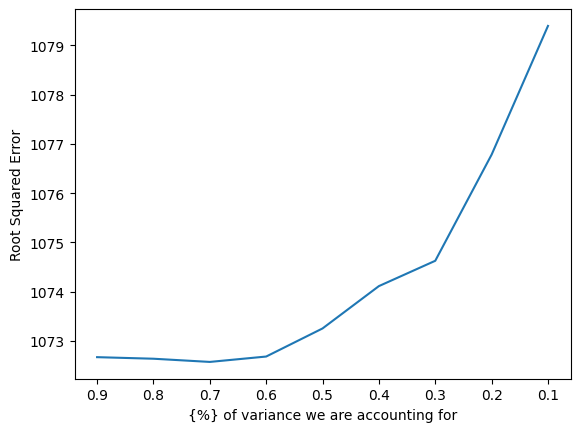

In [382]:
plt.plot(se_list_linear)
plt.xlabel("{%} of variance we are accounting for")
plt.ylabel("Root Squared Error")
plt.xticks(range(len(var)),var)
plt.show()

In [386]:
#an about 1000 error doesnt seem to bad considering the time to arrive on average is 3500.
#This error is more and less relevant as the actual time to arrive is less then or greater then
#IE the longer the actual waiting time, the less impact a 1000 second error on the estimate will make a difference in customer experience

In [387]:
#We should try a neural network with the principal components (if the linear regression results are anything to go off of, we should try 0.6 and 0.7 accounted variance first)
tf.random.set_seed(100)


In [388]:
def neural_net_stoch(feature_set_size):
    model = Sequential()
    model.add(Dense(16, input_dim = feature_set_size , activation='relu'))
    model.add(Dense(1,activation="linear"))

    model.compile(optimizer="sgd" , loss="mse",metrics=[tf.metrics.RootMeanSquaredError()])

    return model

In [389]:
def neural_net(feature_set_size):
    model = Sequential()
    model.add(Dense(16, input_dim = feature_set_size , activation='relu'))
    model.add(Dense(1,activation="linear"))

    model.compile(optimizer="Adam" , loss="mse",metrics=[tf.metrics.RootMeanSquaredError()])

    return model

In [390]:
pca_dict_train[0.6].shape[1]
pca_dict_train[0.6].shape

(141074, 45)

In [391]:
#Fit the model to the PCA data then calculate the root squared error of our predictions to the test set
model_dash = neural_net(pca_dict_train[0.8].shape[1])

fitmodel_dash = model_dash.fit(pca_dict_train[0.8] , y_train , epochs = 100 , batch_size=64, verbose=1)
ypred = model_dash.predict(pca_dict_test[0.8])

Epoch 1/100
2205/2205 [==============================] - 7s 3ms/step - loss: 1824185.7500 - root_mean_squared_error: 1350.6243
Epoch 2/100
2205/2205 [==============================] - 5s 2ms/step - loss: 1269914.2500 - root_mean_squared_error: 1126.9047
Epoch 3/100
2205/2205 [==============================] - 4s 2ms/step - loss: 1247349.8750 - root_mean_squared_error: 1116.8481
Epoch 4/100
2205/2205 [==============================] - 4s 2ms/step - loss: 1240119.5000 - root_mean_squared_error: 1113.6066
Epoch 5/100
2205/2205 [==============================] - 4s 2ms/step - loss: 1238288.2500 - root_mean_squared_error: 1112.7841
Epoch 6/100
2205/2205 [==============================] - 3s 2ms/step - loss: 1236972.2500 - root_mean_squared_error: 1112.1925
Epoch 7/100
2205/2205 [==============================] - 4s 2ms/step - loss: 1235554.5000 - root_mean_squared_error: 1111.5549
Epoch 8/100
2205/2205 [==============================] - 9s 4ms/step - loss: 1234583.6250 - root_mean_squared_e

In [392]:
root_squared_error = mean_squared_error(y_test , ypred,squared=False)
print(f"A neural network using the Adam optimizer gave us a root mean squared error of {root_squared_error}")

A neural network using the Adam optimizer gave us a root mean squared error of 1084.1490568240713


In [393]:
model_dash_stoch = neural_net_stoch(pca_dict_train[0.8].shape[1])

fitmodel_dash_stoch = model_dash_stoch.fit(pca_dict_train[0.8] , y_train , epochs = 25 , batch_size=64, verbose=1)
ypred_stoch = model_dash_stoch.predict(pca_dict_test[0.8])

Epoch 1/25
2205/2205 [==============================] - 10s 4ms/step - loss: 43286055084495743221760.0000 - root_mean_squared_error: 208053010432.0000
Epoch 2/25
2205/2205 [==============================] - 9s 4ms/step - loss: 1332095.1250 - root_mean_squared_error: 1154.1643
Epoch 3/25
2205/2205 [==============================] - 9s 4ms/step - loss: 1332132.7500 - root_mean_squared_error: 1154.1805
Epoch 4/25
2205/2205 [==============================] - 9s 4ms/step - loss: 1332134.1250 - root_mean_squared_error: 1154.1812
Epoch 5/25
2205/2205 [==============================] - 9s 4ms/step - loss: 1332141.8750 - root_mean_squared_error: 1154.1844
Epoch 6/25
2205/2205 [==============================] - 8s 4ms/step - loss: 1332125.8750 - root_mean_squared_error: 1154.1776
Epoch 7/25
2205/2205 [==============================] - 9s 4ms/step - loss: 1332120.7500 - root_mean_squared_error: 1154.1754
Epoch 8/25
2205/2205 [==============================] - 9s 4ms/step - loss: 1331989.1250 - ro

In [394]:
root_squared_error = mean_squared_error(y_test , ypred_stoch,squared=False)
print(f"A neural network using the stochastic gradient descent optimizer gave us a root mean squared error of {root_squared_error}")

A neural network using the stochastic gradient descent optimizer gave us a root mean squared error of 1154.7845011449801


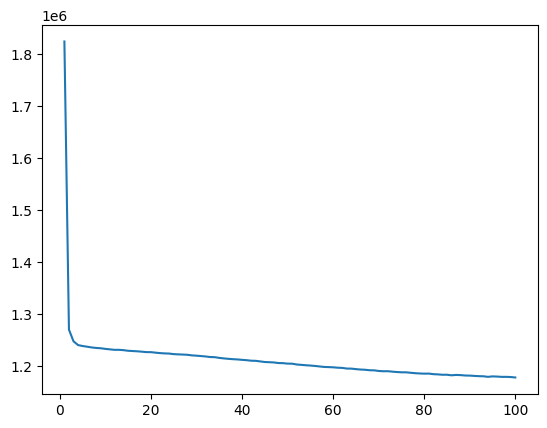

In [395]:
#Make a plot to see the trend and whether running more epochs can help
epochs = range(1,101)
plt.plot(epochs , fitmodel_dash.history["loss"])

In [396]:
#The neural network was almost as efficient as the regression models, we can possibly improve this by deleting some features
#First we call back the original data without the hot encodes
dash_data_no_outlier

,time_to_arrive,total_items,total_free_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,afghan,african,alcohol,alcohol-plus-food,...,sushi,tapas,thai,turkish,vegan,vegetarian,vietnamese,ratio_distinct,price_per_item,range_price
0,3779.0,4.0,0.424242,21.0,446.0,861.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,860.250000,682.0
1,4024.0,1.0,2.000000,2.0,446.0,690.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1900.000000,0.0
2,1781.0,1.0,0.000000,0.0,446.0,690.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1900.000000,0.0
3,3075.0,6.0,1.000000,2.0,446.0,289.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.833333,1150.000000,1200.0
4,2390.0,3.0,1.000000,9.0,446.0,650.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1300.000000,500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197423,3907.0,3.0,1.000000,23.0,251.0,331.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,463.000000,304.0
197424,3383.0,6.0,0.916667,14.0,251.0,915.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,501.666667,420.0
197425,3008.0,5.0,1.051282,40.0,251.0,795.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.600000,367.200000,99.0
197426,3907.0,1.0,1.000000,12.0,446.0,384.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1175.000000,0.0


In [397]:
dash_data_numeric = dash_data_no_outlier[["time_to_arrive",	"total_items"	,"total_free_dashers",	"total_outstanding_orders",	"estimated_order_place_duration",	"estimated_store_to_consumer_driving_duration","ratio_distinct",	"price_per_item",	"range_price"]]

In [398]:
#Create a data set without any category variables
dash_data_numeric

,time_to_arrive,total_items,total_free_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,ratio_distinct,price_per_item,range_price
0,3779.0,4.0,0.424242,21.0,446.0,861.0,1.000000,860.250000,682.0
1,4024.0,1.0,2.000000,2.0,446.0,690.0,1.000000,1900.000000,0.0
2,1781.0,1.0,0.000000,0.0,446.0,690.0,1.000000,1900.000000,0.0
3,3075.0,6.0,1.000000,2.0,446.0,289.0,0.833333,1150.000000,1200.0
4,2390.0,3.0,1.000000,9.0,446.0,650.0,1.000000,1300.000000,500.0
...,...,...,...,...,...,...,...,...,...
197423,3907.0,3.0,1.000000,23.0,251.0,331.0,1.000000,463.000000,304.0
197424,3383.0,6.0,0.916667,14.0,251.0,915.0,0.666667,501.666667,420.0
197425,3008.0,5.0,1.051282,40.0,251.0,795.0,0.600000,367.200000,99.0
197426,3907.0,1.0,1.000000,12.0,446.0,384.0,1.000000,1175.000000,0.0


In [399]:
#implement k-means clustering
#Normalize data
scaler = StandardScaler()
dash_data_numeric_scaled = scaler.fit_transform(dash_data_numeric)
dash_data_numeric_scaled


array([[ 0.80318555,  0.32006224, -1.29222357, ...,  0.53944192,
        -0.22574619,  0.39448873],
       [ 1.01545186, -0.88410098,  2.5790239 , ...,  0.53944192,
         1.79059878, -0.91784506],
       [-0.92786793, -0.88410098, -2.3344825 , ...,  0.53944192,
         1.79059878, -0.91784506],
       ...,
       [ 0.13519644,  0.72144998,  0.24825804, ..., -1.66674386,
        -1.18189804, -0.72734499],
       [ 0.91408387, -0.88410098,  0.1222707 , ...,  0.53944192,
         0.38463571, -0.91784506],
       [-0.5405902 ,  0.32006224,  0.1222707 , ...,  0.53944192,
        -0.6310514 , -0.29246605]])

In [400]:
dash_data.head(1)

,market_id,created_at,actual_delivery_time,time_to_arrive,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_free_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,3779.0,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,0.424242,21.0,446,861.0


In [401]:
#Check how many categories there are for each category variable

#For store primary category
print(dash_data["store_primary_category"].value_counts().count())
#At most we should have 74

#For Market IDs
print(dash_data["market_id"].value_counts().count())

#For order_protocol
print(dash_data["order_protocol"].value_counts().count())


74
6
7


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

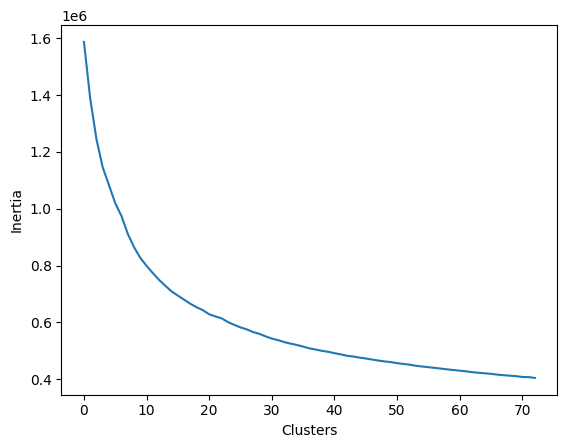

In [402]:
#Create an elbow plot to get a rough idea on how the data is split categorically (if at all)
elbow=[]
for i in range(1,74):
    kmeansmodel = KMeans(n_clusters = i , random_state=10)
    kmeansmodel.fit(dash_data_numeric_scaled)
    elbow.append(kmeansmodel.inertia_)

#Plot
plt.plot(elbow)
plt.xlabel("Clusters")
plt.ylabel("Inertia")
plt.show()



In [410]:
#PCA to visualize data
#First, call back the first data set and drop the null values 
dash_data.head(1)
dash_data.isnull().sum()
dash_data.dropna(inplace=True)

#Remove values such that total_free_dashers is infinity
dash_data.loc[dash_data["total_onshift_dashers"]==0] = None

#Remove the outliers for the sake of visulization
dash_data.loc[dash_data["total_items"]>400] = None

In [411]:
#Check that we got rid of all the null values
dash_data.isnull().sum()

market_id                                       0
created_at                                      0
actual_delivery_time                            0
time_to_arrive                                  0
store_id                                        0
store_primary_category                          0
order_protocol                                  0
total_items                                     0
subtotal                                        0
num_distinct_items                              0
min_item_price                                  0
max_item_price                                  0
total_onshift_dashers                           0
total_busy_dashers                              0
total_free_dashers                              0
total_outstanding_orders                        0
estimated_order_place_duration                  0
estimated_store_to_consumer_driving_duration    0
dtype: int64

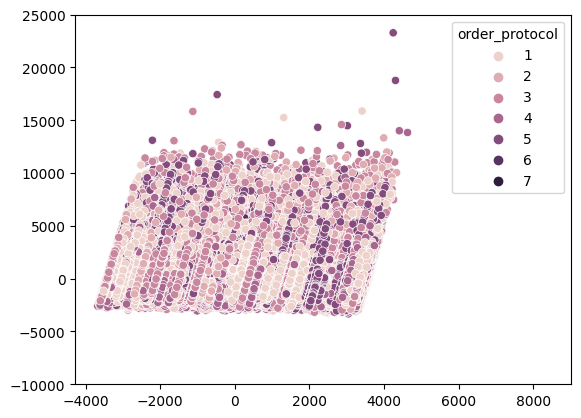

In [412]:

#Take the data and remove the time stamped variables and the string variables
dash_data_for_pca = dash_data.drop(columns=["store_primary_category","created_at","actual_delivery_time"])
scaled_data = scaler.fit_transform(dash_data_for_pca)

#Fit PCA onto the data and make another variable 'Order Protocol' so we can visualize category seperation
pca_numerical,pca_protocol =dash_data_for_pca,dash_data_for_pca["order_protocol"] 
pca = PCA()
pca_dash =pca.fit_transform(pca_numerical)

sns.scatterplot(x = pca_dash[:,0] , y = pca_dash[:,1], hue=pca_protocol)
plt.ylim([-10000,25000])
plt.show()



In [ ]:
#the visulaization tells us there is no discerneable seperation in the data
#From now on, use the numeric set 
dash_data_numeric.head(10)

,time_to_arrive,total_items,total_free_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,ratio_distinct,price_per_item,range_price
0,3779.0,4.0,19.0,21.0,446.0,861.0,1.000000,860.250000,682.0
1,4024.0,1.0,0.0,2.0,446.0,690.0,1.000000,1900.000000,0.0
2,1781.0,1.0,1.0,0.0,446.0,690.0,1.000000,1900.000000,0.0
3,3075.0,6.0,0.0,2.0,446.0,289.0,0.833333,1150.000000,1200.0
4,2390.0,3.0,0.0,9.0,446.0,650.0,1.000000,1300.000000,500.0
5,2300.0,3.0,0.0,2.0,446.0,338.0,1.000000,1666.666667,400.0
6,1584.0,2.0,1.0,9.0,446.0,638.0,1.000000,1950.000000,1500.0
7,1965.0,4.0,0.0,7.0,446.0,626.0,1.000000,1212.500000,1050.0
8,1586.0,4.0,2.0,18.0,446.0,289.0,0.750000,1192.750000,784.0
9,3192.0,2.0,0.0,2.0,446.0,715.0,1.000000,1050.000000,500.0


In [413]:
#Fit a tentative regression model
#First split data into train and test
x = dash_data_numeric.drop(columns = "time_to_arrive")
y = dash_data_numeric["time_to_arrive"]

x_train , x_test , y_train , y_test = train_test_split(x,y , test_size = 0.2,random_state=100)

In [414]:
#Use the regression function from earlier to fit a Tentative model
fitforest = regression(LinearRegression(),x_test,x_train,y_train,y_test)
fitforest[3]



1077.5901383053235

In [415]:
#Try a boosted tree, first we convert the types to xgb data
train_reg = xgb.DMatrix(x_train , y_train)
test_reg = xgb.DMatrix(x_test, y_test)

In [416]:
#Fit a boosted tree on training set
params = {"objective":"reg:squarederror","tree_method":"gpu_hist"}

model = xgb.train(params = params , dtrain = train_reg , num_boost_round = 16)

In [417]:
#Evaluate on test set
pred_boost = model.predict(test_reg)

mean_squared_error(y_test, pred_boost, squared=False)


1050.2535569194704

In [64]:
#Before moving to cross validation lets tune our hyperparametres
#Use grid search to tune parametres, come up with some reasonable parametres
params_tune = {'max_depth':[3,5,6,7,8],'learning_rate':[0.3,0.01,0.1,0.2],'n_estimators':[15,16,17,18],'subsample':[0.6,0.7,0.8]}

#specify the XGB regressor, create a function that can do this 
def booster_tune(predictor,target,para_tests):
    xgbr = xgb.XGBRegressor(seed=100)

#Run Grid search
    search = GridSearchCV(estimator=xgbr , param_grid=para_tests , scoring='neg_mean_squared_error',verbose=1)

    search.fit(predictor,target)

    return search.best_params_

In [419]:
#Using these parametreswe fit the boost model 
tuned_params = {"objective":"reg:squarederror","tree_method":"gpu_hist",'learning_rate': 0.3, 'max_depth': 5, 'subsample': 0.8}


model_tuned = xgb.train(params = tuned_params , dtrain = train_reg , num_boost_round = 18)


In [420]:
pred_boost = model_tuned.predict(test_reg)

mean_squared_error(y_test, pred_boost, squared=False)


1048.7022972049608

In [424]:
#Since we have a somewhat limited data set we can try k-fold cross validation to further valdiate the model
validated_xg = xgb.cv(params=tuned_params , dtrain = train_reg , num_boost_round=40 ,nfold=5)
 
validated_xg.min()


train-rmse-mean    1024.505769
train-rmse-std        6.630072
test-rmse-mean     1045.748041
test-rmse-std        27.447854
dtype: float64

Text(0.5, 0, 'Round')

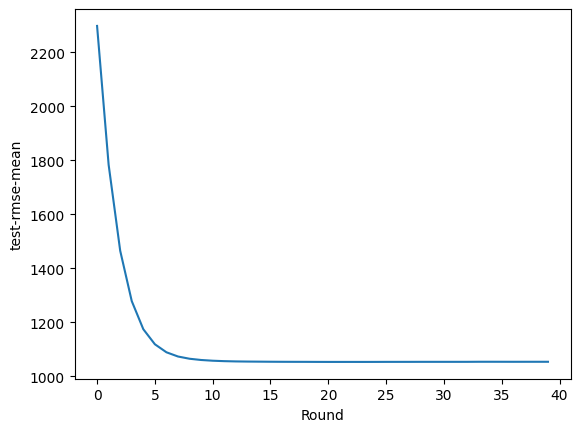

In [ ]:
plt.plot(validated_xg['test-rmse-mean'])
plt.ylabel("test-rmse-mean")
plt.xlabel('Round')



In [ ]:
sns.pairplot(dash_data_numeric)

In [ ]:
x

,total_items,total_free_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,ratio_distinct,price_per_item,range_price
0,4.0,19.0,21.0,446.0,861.0,1.000000,860.250000,682.0
1,1.0,0.0,2.0,446.0,690.0,1.000000,1900.000000,0.0
2,1.0,1.0,0.0,446.0,690.0,1.000000,1900.000000,0.0
3,6.0,0.0,2.0,446.0,289.0,0.833333,1150.000000,1200.0
4,3.0,0.0,9.0,446.0,650.0,1.000000,1300.000000,500.0
...,...,...,...,...,...,...,...,...
197423,3.0,0.0,23.0,251.0,331.0,1.000000,463.000000,304.0
197424,6.0,1.0,14.0,251.0,915.0,0.666667,501.666667,420.0
197425,5.0,0.0,40.0,251.0,795.0,0.600000,367.200000,99.0
197426,1.0,0.0,12.0,446.0,384.0,1.000000,1175.000000,0.0


[0.10145574 0.19240773 0.14938132 0.26582545 0.15307339 0.02607176
 0.06237682 0.04940776]


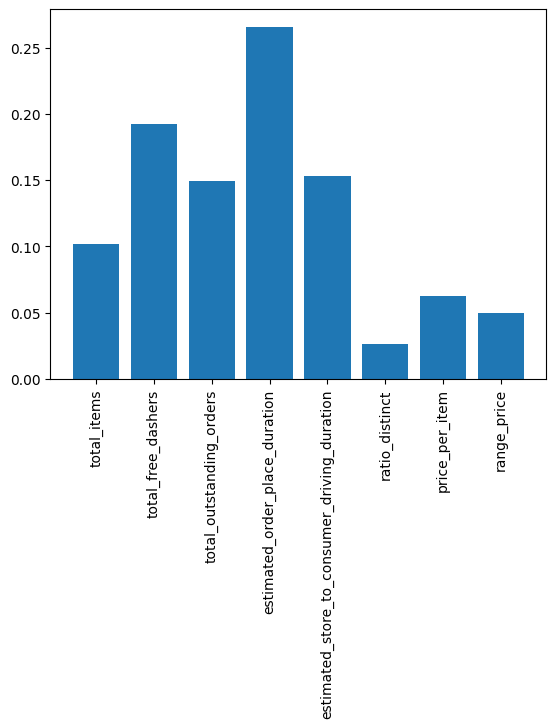

In [ ]:
#Use XG boost built in feature importance plot
xgb_regressor = xgb.XGBRegressor()
xgb_regressor.fit(x,y)
print(xgb_regressor.feature_importances_)

plt.bar(x.columns,xgb_regressor.feature_importances_)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
#Try dropping Ratio Distinct
#dash_data_numeric.drop(columns="ratio_distinct" , inplace=True)

#Split test and training
x=dash_data_numeric.drop(columns = "time_to_arrive")
y=dash_data_numeric["time_to_arrive"]
x_train , x_test , y_train , y_test = train_test_split(x,y , test_size = 0.2,random_state=100)

In [ ]:
train_reg = xgb.DMatrix(x_train , y_train)
test_reg = xgb.DMatrix(x_test, y_test)

In [ ]:
validated_xg = xgb.cv(params=tuned_params , dtrain = train_reg , num_boost_round=40 ,nfold=5)
 
validated_xg

In [ ]:
y = booster_tune(x,y,params_tune)
print(y)

In [ ]:
#Turn the target variables into arrays to feed into
y_train_array = np.array(y_train)
y_test_array = np.array(y_test)

y_test_array = y_test_array.reshape(len(y_test_array),1)
y_train_array = y_train_array.reshape(len(y_train_array),1)
